# Red Giant Classification Project

**The goal - predicting the evolutionary stage of Red Giant stars**

## initializing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# all altair plots were saved and uploaded as pictures to lighten the notebook
while True:
    try:
        import altair as alt
        break
    except ModuleNotFoundError:
        !pip install altair

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

### plotting defs

In [2]:
def plot_target_distro(data, target='phase'):
    
    base = alt.Chart(data).encode(
        x=alt.X('phase:N', title=None, ),
        y=alt.Y(f'count({target}):Q', title=None)
    ).properties(width=300)

    bar = base.mark_bar(
        size=100,
        color='indianred')

    text = base.mark_text(
        baseline='top', dy=20,
        size=25, color='mistyrose'
    ).encode(text=f'count({target}):Q')

    return bar+text

In [3]:
def plot_feature_importances(model):

    features = model.feature_names_in_
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_

    elif hasattr(model, 'steps'):
        name, estimator = model.steps[-1]
        importances = estimator.feature_importances_

    else:
        print('no feature importances for this model')
        pass
        
    feat_chart = alt.Chart(pd.DataFrame(
        {'feature': features, 'importance': importances}
    ).sort_values('importance').tail(10),
        title='feature importances').mark_bar(
        color='firebrick').encode(
        y=alt.Y('feature:N', sort='-x', title=None),
        x=alt.X('importance:Q', title=None, axis=alt.Axis(format='.0%'))
    ).properties(height=150, width=400)
    
    return feat_chart

In [4]:
def plot_confusion_matrix(model, X, y, stage):

    conf_df = pd.DataFrame(
        confusion_matrix(
            y, model.predict(X),
            labels=model.classes_),
        index=model.classes_,
        columns=model.classes_)

    base = alt.Chart(
        conf_df.reset_index().melt(id_vars='index'),
        title=f'{stage} confusion matrix'
    ).encode(x=alt.X('index:N', title=None),
             y=alt.Y('variable:N', title=None)
             ).properties(height=175, width=175)

    heatmap = base.mark_rect().encode(
        color=alt.Color('value:Q',
                        scale=alt.Scale(
                            scheme='reds'),
                        legend=None))

    text = base.mark_text(
        baseline='middle', size=25
    ).encode(text='value:Q',
             color=alt.condition(
                 'datum.value < 3000',
                 alt.value('darkred'),
                 alt.value('tomato'))
             ).encode()

    return heatmap+text

In [5]:
def plot_score_comp(scores, comp_var):
    return alt.Chart(scores).mark_bar().encode(
        x=alt.X('stage:N', axis=None, sort='-x'),
        y=alt.Y('score:Q', axis=alt.Axis(format='%'),
                scale=alt.Scale(domain=(.9, 1))),
        color=alt.Color('stage:N', sort=['train', 'test'],
                        scale=alt.Scale(scheme='reds')),
        column=f'{comp_var}:N').properties(width=75)

## small exploration

In [6]:
upload = pd.read_csv('/'.join(['https:/',
                               'raw.githubusercontent.com',
                               'Morshay',
                               'red-giant-blue-giant',
                               'main',
                               'data',
                               'clean_data.csv']))

### data overview

In [7]:
init_df = upload.copy()
print(init_df.info())
init_df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15388 entries, 0 to 15387
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   phase   15388 non-null  object 
 1   ap_mag  15388 non-null  float64
 2   freq    15388 non-null  float64
 3   fr_sep  15388 non-null  float64
 4   amp     14851 non-null  float64
 5   pow_ex  14851 non-null  float64
 6   temp    15388 non-null  int64  
 7   grav    15388 non-null  float64
 8   metal   15388 non-null  float64
 9   rad     15388 non-null  float64
 10  mass    15388 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 1.3+ MB
None


,phase,ap_mag,freq,fr_sep,amp,pow_ex,temp,grav,metal,rad,mass
779,RGB,15.92,63.23,6.649,89.9,21.7,4589,2.699,-1.84,21.29,2.76
2361,HeB,13.43,35.18,4.157,100.6,15.8,4974,2.462,-0.21,33.32,3.92
2837,RGB,12.05,152.78,13.118,47.3,43.2,4803,3.092,-0.36,14.06,2.97
9354,HeB,12.27,30.06,3.279,88.6,11.0,4933,2.392,-0.07,45.63,6.23
11801,RGB,13.27,196.13,14.762,23.2,55.0,5104,3.214,-0.06,15.04,4.49
921,HeB,13.38,32.88,4.090,137.6,15.3,4890,2.429,0.17,32.05,3.35
9671,RGB,13.25,173.46,14.058,51.4,44.3,5037,3.158,0.09,14.58,3.72
11929,RGB,13.99,58.49,5.895,97.3,18.3,4881,2.679,0.34,27.35,4.33
3226,HeB,12.16,36.44,4.212,94.9,15.2,4707,2.465,-0.11,32.26,3.69
4807,RGB,11.56,63.38,6.250,82.7,20.9,4747,2.707,0.15,25.82,4.13


In [8]:
# plot_target_distro(init_df)

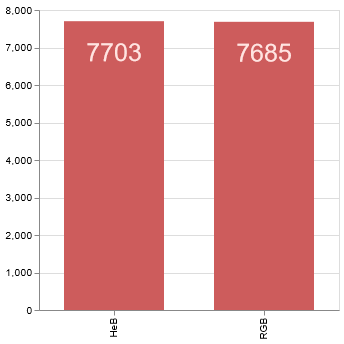

### quick test

prior to testing - success in my view would be around 80% accuracy score, and 90% would be a smashing hit.

In [9]:
def quick_test(data, target='phase'):

    X, y = data.drop(columns=target).fillna(0), data[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.3, random_state=6582119, stratify=y, shuffle=True)

    m = RandomForestClassifier(
        max_samples=.25,
        n_estimators=10,
        random_state=6582119
    ).fit(X_train, y_train)
    
    conf_train = plot_confusion_matrix(m, X_train, y_train, 'train')
    conf_test = plot_confusion_matrix(m, X_test, y_test, 'test')
    feat = plot_feature_importances(m)
    
    res = (conf_train | conf_test) & feat
    
    return res

In [10]:
def print_clf_report(data, target='phase'):
    
    X, y = data.drop(columns='phase').fillna(0), data.phase

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=.3, random_state=6582119, stratify=y, shuffle=True)

    m = RandomForestClassifier(
        max_samples=.25, n_estimators=10, random_state=6582119)
    
    m.fit(X_train, y_train)
    
    print(classification_report(y_test, m.predict(X_test), target_names=m.classes_))

In [11]:
# quick_test(init_df)

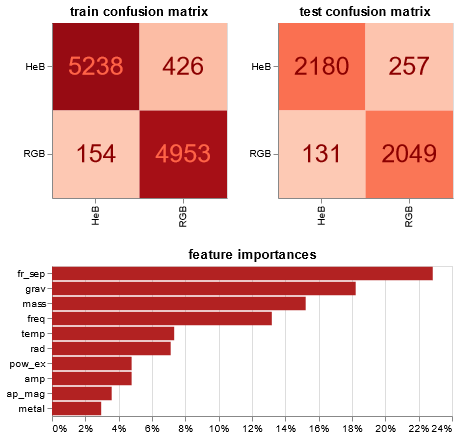

In [12]:
print_clf_report(init_df)

              precision    recall  f1-score   support

         HeB       0.89      0.94      0.92      2311
         RGB       0.94      0.89      0.91      2306

    accuracy                           0.92      4617
   macro avg       0.92      0.92      0.92      4617
weighted avg       0.92      0.92      0.92      4617



just because the results are great, doesn't mean that nothing can be done with the data.

In [13]:
df = init_df.copy()

## feature engineering

### feature selection

In [14]:
feat_df = df.copy()

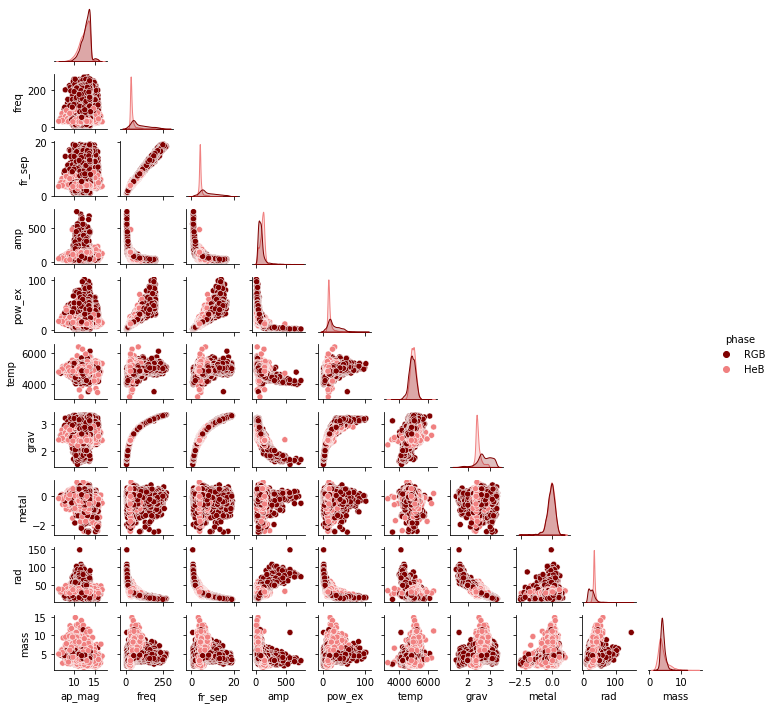

In [15]:
sns.pairplot(
    feat_df, height=1, corner=True,
    hue='phase', palette=['maroon', 'lightcoral'])

there seems to be a clear mapping between each of the following five columns:
- frequency
- freq. sep.
- amplitude
- power excess
- gravity
- radius

weirdly enough, the mass column is pretty unrelated to those.

the only column there which has an even distribution between the two classes is the amplitude column.  
it'll be the one to keep, expecting the results to go down.

In [16]:
feat_df.drop(columns=['freq', 'fr_sep', 'pow_ex', 'grav', 'rad'], inplace=True)

In [17]:
# quick_test(feat_df)

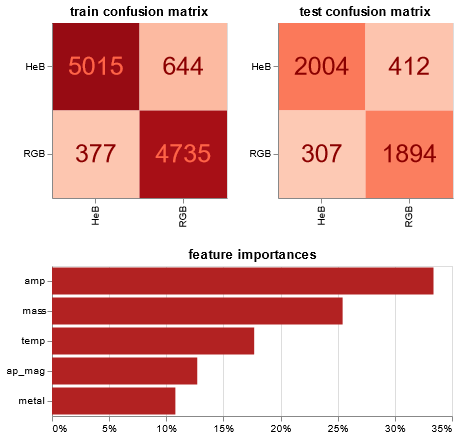

In [18]:
df = feat_df.copy()

### nulls

In [19]:
null_df = df.copy()

In [20]:
tot_nulls = len(null_df[null_df.isnull().any(axis='columns')])

print(f'{tot_nulls/len(null_df):.2%}')

3.49%


In [21]:
null_df.columns[null_df.isnull().sum() > 0]

Index(['amp'], dtype='object')

totally negeligible, still i'll fill those in with group means, using the metallicity column to group by, since it's the most evenly distributed.

In [22]:
null_df['bins'] = pd.cut(null_df.metal, bins=10)
null_df.bins.value_counts()

(-0.4, -0.05]      6318
(-0.05, 0.3]       5807
(-0.75, -0.4]      1895
(0.3, 0.65]         848
(-1.1, -0.75]       360
(-1.45, -1.1]        92
(-1.8, -1.45]        28
(-2.15, -1.8]        19
(0.65, 1.0]          13
(-2.504, -2.15]       8
Name: bins, dtype: int64

In [23]:
null_df.amp.fillna(null_df.groupby(
    ['bins'])['amp'].transform('mean'), inplace=True)
null_df.isna().any(axis=1).sum()

0

In [24]:
null_df.drop(columns='bins', inplace=True)

In [25]:
# quick_test(null_df)

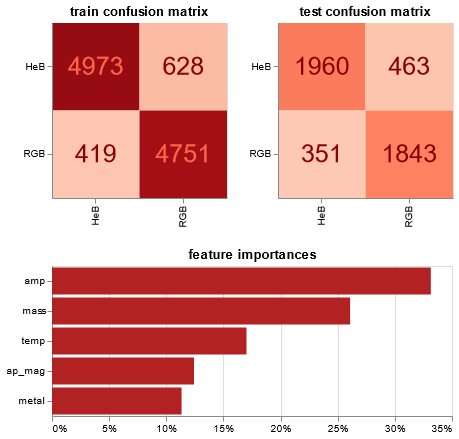

well, that went horribly wrong.  
the reason for that is that a mapping between 2 columns doesn't imply redundancy.  
maybe it's time to try a different approach.

### a different approach

in this approach, i use sklearn's models for data optimization.

In [26]:
new_df = init_df.copy()

In [27]:
X, y = new_df.drop(columns='phase'), new_df.phase

null filling 

In [28]:
imputer = SimpleImputer() # fills nulls with column mean
X_imp = pd.DataFrame(
    imputer.fit_transform(X),
    columns=X.columns)

feature selection

In [29]:
def calc_k_best_score(k_val, X, y):

    selector = SelectKBest(k=k_val)

    X_slc = pd.DataFrame(
        selector.fit_transform(X_imp, y),
        columns=X_imp.columns[selector.get_support()])

    X_train, X_test, y_train, y_test = train_test_split(
        X_slc, y, test_size=.3, random_state=6582119, stratify=y, shuffle=True)

    m = RandomForestClassifier(
        max_samples=.25,
        n_estimators=10,
        random_state=6582119
    ).fit(X_train, y_train)

    scores_df = scores_df = pd.DataFrame(
        columns=['k_value', 'stage', 'score'],
        data=[[k_val, 'train', m.score(X_train, y_train)],
              [k_val, 'test', m.score(X_test, y_test)]])
    
    return scores_df

In [30]:
# k_best_data = pd.concat(
#     [calc_k_best_score(k, X_imp, y)
#      for k in range(4, 11)]
# ).reset_index(drop=True)

# plot_score_comp(k_best_data, 'k_value')

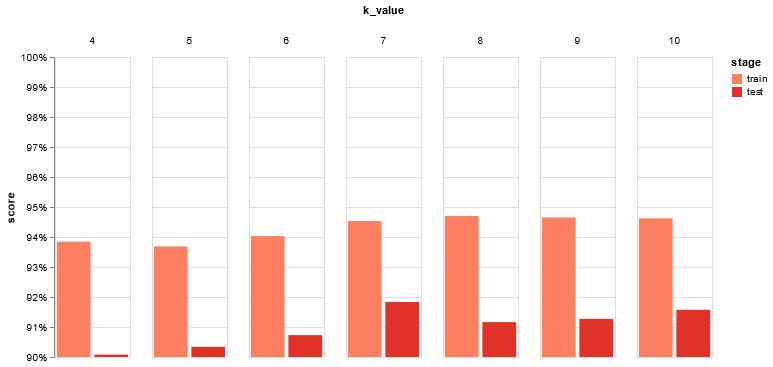

it seems as if there is an upward score trend, with an anomaly at k=7. i'll keep that in mind moving forward.

In [31]:
k7_selector = SelectKBest(k=7)

X_k7 = pd.DataFrame(
    k7_selector.fit_transform(X_imp, y),
    columns=X_imp.columns[k7_selector.get_support()])

k7_df = pd.concat([y, X_k7], axis=1)

In [32]:
k10_selector = SelectKBest(k=10)

X_k10 = pd.DataFrame(
    k10_selector.fit_transform(X_imp, y),
    columns=X_imp.columns[k10_selector.get_support()])

k10_df = pd.concat([y, X_k10], axis=1)

## model comparison

testing the final data on different models and optimize them using a grid search to see which one fits best.

### k=7

In [33]:
X, y = k7_df.drop(columns='phase'), k7_df.phase

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=6582119, stratify=y, shuffle=True)

**random forest**

In [34]:
forest_base = RandomForestClassifier(
    max_samples=.25, n_estimators=10
).fit(X_train, y_train)

forest_params = {'n_estimators': [50, 100, 150],
              'max_samples': [.15, .2, .25, .3, .35]}

forest_gs = GridSearchCV(
    forest_base, forest_params, cv=5
).fit(X_train, y_train)

forest_gs.best_params_

{'max_samples': 0.25, 'n_estimators': 100}

**SVM**

In [35]:
svm_base = SVC(gamma=1e-3, C=10).fit(X_train, y_train)

svm_params = {'gamma': [1e-4, 1e-3, 1e-2],
              'C': [1, 10, 100]}

svm_gs = GridSearchCV(svm_base, svm_params, cv=5)
svm_gs.fit(X_train, y_train)
svm_gs.best_params_

{'C': 100, 'gamma': 0.0001}

**logistic regression**

In [36]:
scaler = StandardScaler()
Xtr_scl = scaler.fit_transform(X_train, y_train)
Xts_scl = scaler.fit_transform(X_test, y_test)

logreg_base = LogisticRegression(
    max_iter=300, C=10).fit(Xtr_scl, y_train)

logreg_params = {'max_iter': [100, 300, 500],
              'C': [.1, 1, 10, 100, 1000]}

logreg_gs = GridSearchCV(
    logreg_base, logreg_params, cv=5
).fit(Xtr_scl, y_train)
logreg_gs.best_params_

{'C': 1000, 'max_iter': 100}

**gradient boosting**

In [37]:
grad_base = GradientBoostingClassifier(
    n_estimators=100, max_depth=5).fit(X_train, y_train)

grad_params = {'n_estimators': [50, 100, 150],
              'max_depth': [3, 5, 7]}
grad_gs = GridSearchCV(grad_base, grad_params, cv=5)
grad_gs.fit(X_train, y_train)
grad_gs.best_params_

{'max_depth': 7, 'n_estimators': 150}

**saving data**

In [38]:
k7_scores_df = pd.DataFrame(
    columns=['model', 'stage', 'score'],
    data=[['k=7 forest', 'train', forest_gs.score(X_train, y_train)],
          ['k=7 forest', 'test', forest_gs.score(X_test, y_test)],
          ['k=7 svm', 'train', svm_gs.score(X_train, y_train)],
          ['k=7 svm', 'test', svm_gs.score(X_test, y_test)],
          ['k=7 logreg', 'train', logreg_gs.score(Xtr_scl, y_train)],
          ['k=7 logreg', 'test', logreg_gs.score(Xts_scl, y_test)],
          ['k=7 grad', 'train', grad_gs.score(X_train, y_train)],
          ['k=7 grad', 'test', grad_gs.score(X_test, y_test)]])

### k=10

In [39]:
X, y = k10_df.drop(columns='phase'), k10_df.phase

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=6582119, stratify=y, shuffle=True)

**random forest**

In [40]:
forest_base = RandomForestClassifier(
    max_samples=.25, n_estimators=10
).fit(X_train, y_train)

forest_params = {'n_estimators': [50, 100, 150],
              'max_samples': [.15, .2, .25, .3, .35]}

forest_gs = GridSearchCV(
    forest_base, forest_params, cv=5
).fit(X_train, y_train)

forest_gs.best_params_

{'max_samples': 0.35, 'n_estimators': 150}

**SVM**

In [41]:
svm_base = SVC(gamma=1e-3, C=10).fit(X_train, y_train)

svm_params = {'gamma': [1e-4, 1e-3, 1e-2],
              'C': [1, 10, 100]}

svm_gs = GridSearchCV(svm_base, svm_params, cv=5)
svm_gs.fit(X_train, y_train)
svm_gs.best_params_

{'C': 100, 'gamma': 0.0001}

**logistic regression**

In [42]:
scaler = StandardScaler()
Xtr_scl = scaler.fit_transform(X_train, y_train)
Xts_scl = scaler.fit_transform(X_test, y_test)

logreg_base = LogisticRegression(
    max_iter=300, C=10).fit(Xtr_scl, y_train)

logreg_params = {'max_iter': [100, 300, 500],
              'C': [.1, 1, 10, 100, 1000]}

logreg_gs = GridSearchCV(
    logreg_base, logreg_params, cv=5
).fit(Xtr_scl, y_train)
logreg_gs.best_params_

{'C': 100, 'max_iter': 100}

**gradient boosting**

In [43]:
grad_base = GradientBoostingClassifier(
    n_estimators=100, max_depth=5).fit(X_train, y_train)

grad_params = {'n_estimators': [50, 100, 150],
              'max_depth': [3, 5, 7]}
grad_gs = GridSearchCV(grad_base, grad_params, cv=5)
grad_gs.fit(X_train, y_train)
grad_gs.best_params_

{'max_depth': 7, 'n_estimators': 100}

**all data**

In [44]:
k10_scores_df = pd.DataFrame(
    columns=['model', 'stage', 'score'],
    data=[['k=10 forest', 'train', forest_gs.score(X_train, y_train)],
          ['k=10 forest', 'test', forest_gs.score(X_test, y_test)],
          ['k=10 svm', 'train', svm_gs.score(X_train, y_train)],
          ['k=10 svm', 'test', svm_gs.score(X_test, y_test)],
          ['k=10 logreg', 'train', logreg_gs.score(Xtr_scl, y_train)],
          ['k=10 logreg', 'test', logreg_gs.score(Xts_scl, y_test)],
          ['k=10 grad', 'train', grad_gs.score(X_train, y_train)],
          ['k=10 grad', 'test', grad_gs.score(X_test, y_test)]])

### comparison plot

In [45]:
all_scores_df = k7_scores_df.append(k10_scores_df)

In [46]:
# plot_score_comp(all_scores_df[all_scores_df.score > .9], 'model')

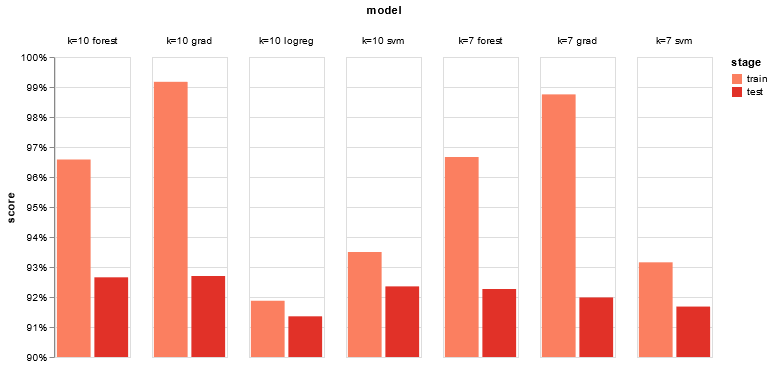

the jury is out - k=10 gradient boosting is the best option. k=7 anomaly was probably a case of overfitting.  
most likely due to the dependency between the 7 columns that have a clear mapping between them.  
also notice how logistic regression is not on the chart because it scored below 90%

## final results

In [47]:
final_df = k10_df.copy()

X, y = final_df.drop(columns='phase'), final_df.phase

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=6582119, stratify=y, shuffle=True)

final_model = GradientBoostingClassifier(
    max_depth=7,
    n_estimators=150,
    random_state=6582119
).fit(X_train, y_train)

In [48]:
print(classification_report(y_test, final_model.predict(X_test),
                      target_names=final_model.classes_))

              precision    recall  f1-score   support

         HeB       0.93      0.93      0.93      2311
         RGB       0.93      0.93      0.93      2306

    accuracy                           0.93      4617
   macro avg       0.93      0.93      0.93      4617
weighted avg       0.93      0.93      0.93      4617



In [49]:
# conf_train = plot_confusion_matrix(final_model, X_train, y_train, 'train')
# conf_test = plot_confusion_matrix(final_model, X_test, y_test, 'test')
# feat = plot_feature_importances(final_model)

# (conf_train | conf_test) & feat

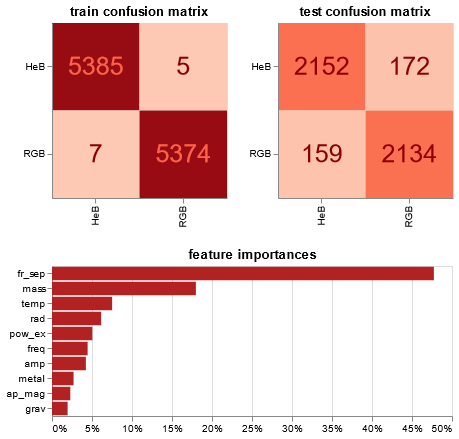

most definitely an improvement in results.

### post-analysis

#### error plot

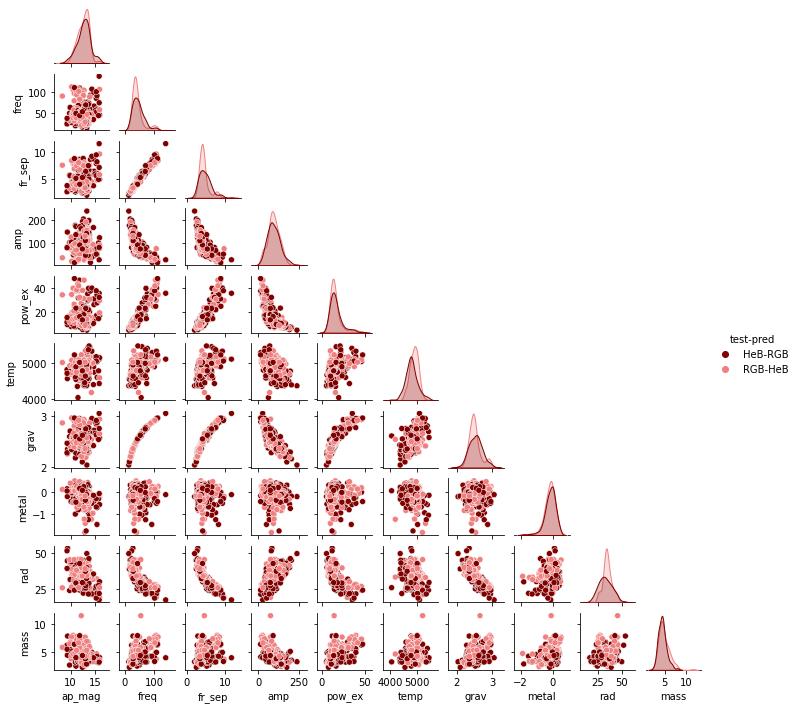

In [50]:
errors_df = X_test.assign(phase=y_test, pred=final_model.predict(X_test))

errors_df['test-pred'] = errors_df.phase + '-' + errors_df.pred

sns.pairplot(
    data=errors_df.loc[errors_df['phase'] != errors_df['pred']],
    hue='test-pred', palette=['maroon', 'lightcoral'], corner=True, height=1)

the prediction errors in are scattered all over the place, so there's no apparent threshold to adjust.

#### roc and auc

In [51]:
def plot_roc_with_auc(model, Xts, yts):
    probas = model.predict_proba(Xts)[:, 1]

    roc = pd.DataFrame(dict(zip(
        ['fpr', 'tpr', 'thrsh'],
        roc_curve(yts, probas, pos_label='RGB'))))

    auc = roc_auc_score(yts, probas)

    return alt.Chart(
        roc, title=f'area under curve = {auc:.2f}'
    ).mark_area(
        color='#de2d26', opacity=0.3,
        line={'color': '#a50f15', 'width': 2}
    ).encode(
        x=alt.X('fpr', title="false positive rate"),
        y=alt.Y('tpr', title="true positive rate")
    ).properties(height=300, width=300)

In [52]:
# plot_roc_with_auc(final_model, X_test, y_test)

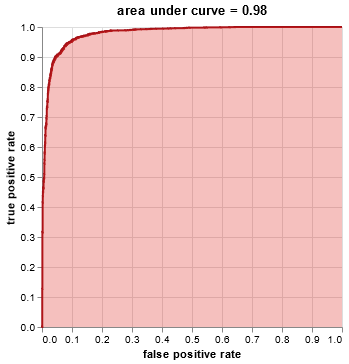

## addendum - pipeline

### setup

In [53]:
X, y = init_df.drop(columns='phase'), init_df.phase

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.3, random_state=6582119, stratify=y, shuffle=True)

best_params = {'max_depth': 7, 'n_estimators': 150}

grad_boost = GradientBoostingClassifier(**best_params, random_state=6582119)

In [54]:
pipeline = Pipeline([(
    'imputer', SimpleImputer()),
    ('selector', SelectKBest()),  # same as k=10
    ('model', grad_boost)]
).fit(X_train, y_train)

### results

In [55]:
print(classification_report(y_test, pipeline.predict(X_test),
                      target_names=pipeline.classes_))

              precision    recall  f1-score   support

         HeB       0.93      0.93      0.93      2311
         RGB       0.93      0.93      0.93      2306

    accuracy                           0.93      4617
   macro avg       0.93      0.93      0.93      4617
weighted avg       0.93      0.93      0.93      4617



In [56]:
# conf_train = plot_confusion_matrix(pipeline, X_train, y_train, 'train')
# conf_test = plot_confusion_matrix(pipeline, X_test, y_test, 'test')
# feat = plot_feature_importances(pipeline)
# roc = plot_roc_with_auc(pipeline, X_test, y_test)

# ((conf_train | conf_test) & feat) | roc.properties(height=400, width=400)

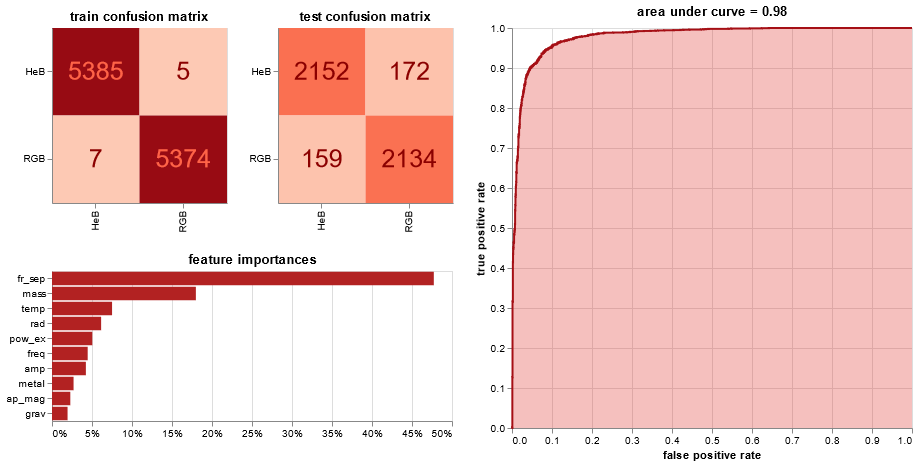

as expected - the exact same results as the regular test, which means a pipeline build is compatible here!